<a href="https://colab.research.google.com/github/farhadrgh/machine-learning/blob/master/DNN_XOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data generation

In [0]:
import numpy as np
X = np.array([[1, 0],
              [-1,0],
              [0, 1],
              [0,-1]]).reshape(4,2)

y = np.array([1, 1, 0, 0]).reshape(4,1)

def rand():
  return 2 * np.random.rand() - 1

for i in range(int(96/2)):
  
  # class one
  x11 = 1./rand() # |x|>1
  x12 = rand()    # |x|<1
  X = np.concatenate((X,np.array([x11,x12]).reshape(1,2)))
  y = np.concatenate((y,np.ones((1,1))))
  
  # class two
  x21 = rand()    # |x|<1
  x22 = 1./rand() # |x|>1
  X = np.concatenate((X,np.array([x21,x22]).reshape(1,2)))
  y = np.concatenate((y,np.zeros((1,1))))

## Random patterns generated from the above algorithm

In [0]:
xy = np.concatenate((X,y), axis=1)
print(xy)

[[ 1.00000000e+00  0.00000000e+00  1.00000000e+00]
 [-1.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.00000000e+00  0.00000000e+00]
 [-3.22033505e+00  8.80214965e-01  1.00000000e+00]
 [ 1.64028360e-01  1.31984632e+00  0.00000000e+00]
 [ 1.45039176e+00  8.10784637e-01  1.00000000e+00]
 [-8.02394684e-02  1.07882276e+01  0.00000000e+00]
 [ 1.67446077e+00 -4.28562297e-01  1.00000000e+00]
 [-1.94929548e-02  5.04488395e+00  0.00000000e+00]
 [-1.03206263e+00  1.86962816e-01  1.00000000e+00]
 [-1.32647302e-01  1.62675410e+00  0.00000000e+00]
 [-2.70628382e+00  7.85777417e-01  1.00000000e+00]
 [ 1.55714431e-01 -1.58232956e+00  0.00000000e+00]
 [ 1.73653781e+00  2.24062354e-01  1.00000000e+00]
 [-8.92181456e-01 -6.26516797e+00  0.00000000e+00]
 [ 2.79222231e+00  8.37203556e-01  1.00000000e+00]
 [-9.99195950e-01  1.04874757e+00  0.00000000e+00]
 [-4.05121759e+00  9.47567077e-01  1.00000000e+00]
 [ 2.09432202e-01  1.52046944e+

## L-Layered Network from scratch
### Fully connected multi-layer backpropagation network from scratch using sigmoidal units (including in the output layer and using cross-entropy as the output measure). 

In [0]:
#@title Helper functions { run: "auto", vertical-output: true, display-mode: "form" }
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache


def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)
    return dZ    


def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)         
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
    return parameters

  
def linear_forward(A, W, b):
    Z = W.dot(A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    return Z, cache

  
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    return A, cache

  
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2               
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "sigmoid")
        caches.append(cache)
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    assert(AL.shape == (1,X.shape[1]))
    return AL, caches

  
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    cost = np.squeeze(cost)      
    assert(cost.shape == ())
    return cost

  
def linear_backward(dZ, cache): 
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    return dA_prev, dW, db

  
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache    
    if activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

  
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "sigmoid")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

  
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    return parameters

def predict(X, y, parameters):

    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [0]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 100, print_cost=False):
    
    np.random.seed(1)
    costs = []                         # keep track of cost
    
    parameters = initialize_parameters_deep(layers_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
       
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
       
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per 1000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.751592
Cost after iteration 1000: 0.590565
Cost after iteration 2000: 0.066585
Cost after iteration 3000: 0.022900
Cost after iteration 4000: 0.013369
Cost after iteration 5000: 0.009370
Cost after iteration 6000: 0.007193
Cost after iteration 7000: 0.005829
Cost after iteration 8000: 0.004897
Cost after iteration 9000: 0.004219


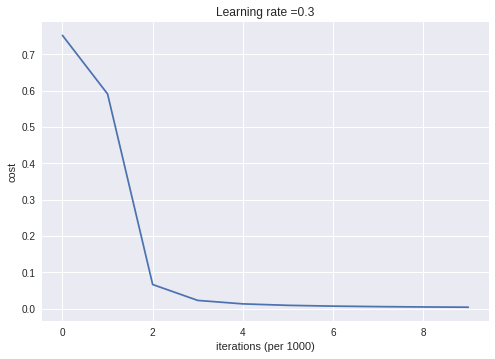

Accuracy: 0.9999999999999999


In [0]:
layers_dims = [2,3,3,1] #  4-layer model
train_x = X.T
train_y = Y.T
parameters = L_layer_model(train_x, train_y, layers_dims, learning_rate = 0.3, num_iterations = 10000, print_cost = True)
pred_train = predict(train_x, train_y, parameters)

### Weights *Wi* for ith hidden layer

In [0]:
for key, val in parameters.items(): print(key, val)

W1 [[ 3.71940342 -0.08965171]
 [-3.05380699 -3.80788149]
 [ 4.07203358 -3.00010779]]
b1 [[ 3.78650436]
 [-0.33746492]
 [-0.82857617]]
W2 [[ 6.22649367 -5.46114302  4.23146422]
 [ 1.07483559  2.63570984 -2.91823744]
 [-1.87253812 -6.61112691  6.83821268]]
b2 [[-0.20811429]
 [ 0.81092533]
 [-1.85079518]]
W3 [[-12.15373034  -1.31258669  12.01889972]]
b3 [[6.91236246]]


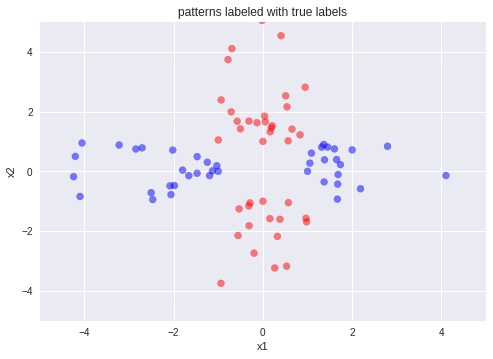

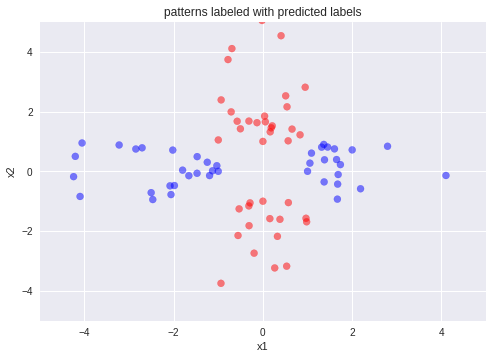

In [0]:
import matplotlib.pyplot as plt
color = ['red', 'blue']
plt.scatter(X[:,0],X[:,1],c=[color[int(i)] for i in y],alpha=0.5)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.title('patterns labeled with true labels')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

data = pred_train.T 
color = ['red', 'blue']
plt.scatter(X[:, 0], X[:, 1], c=[color[int(i)] for i in data],alpha=0.5)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.title('patterns labeled with predicted labels')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()


## Keras


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 3)                 9         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 12        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 4         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
100/100 [==============================] - 0s 3ms/step - loss: 0.7280 - binary_accuracy: 0.5100
Epoch 2/100
100/100 [==============================] - 0s 155us/step - loss: 0.7165 - binary_accuracy: 0.4700
Epoch 3/100
100/100 [==============================] - 0s 147us/step - loss: 0.6999 - binary_accuracy: 0.5100
Epoch 4/100
100/100 [==============================] - 0s 140us/step - loss: 0.705

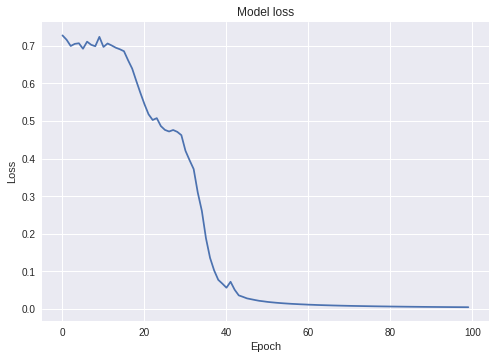

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
import matplotlib.pyplot as plt

#Y = keras.utils.to_categorical(y,num_classes=2) # 100 x 2
layer = 2
Y = y
model = Sequential()
model.add(Dense(3, activation='sigmoid', input_dim=2))
for _ in range(layer-1):
  model.add(Dense(3, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.SGD(lr=0.3, momentum=0.9, nesterov=True), metrics=[keras.metrics.binary_accuracy])

model.summary()
history = model.fit(X, Y, epochs=100, batch_size=10)
loss_and_metrics = model.evaluate(X, Y)
classes = model.predict(X)
#print(classes)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

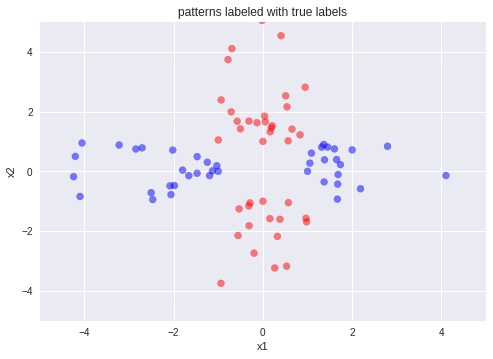

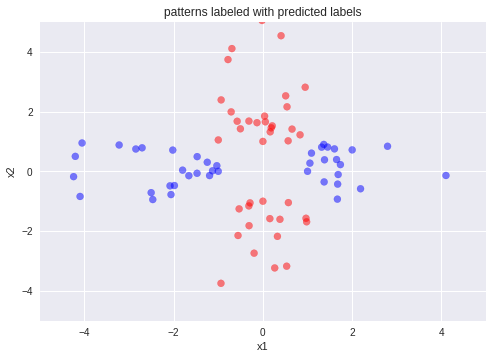

In [0]:
import matplotlib.pyplot as plt
color = ['red', 'blue']
plt.scatter(X[:,0],X[:,1],c=[color[int(i)] for i in y],alpha=0.5)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.title('patterns labeled with true labels')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

data = classes 
data[(data > 0.5)] = 1
data[(data <= 0.5)] = 0
color = ['red', 'blue']
plt.scatter(X[:, 0], X[:, 1], c=[color[int(i)] for i in data],alpha=0.5)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.title('patterns labeled with predicted labels')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

*Report on the minimum number of layers required for obtaining 100% classification while using three hidden units per layer. Also, report all weights and the corresponding hidden unit rules (for arbitrary inputs). Other parameters (sigmoidal slope parameter, learning rate, number of epochs for convergence etc.) should also be recorded and reported. Compare your results with TensorFlow/Keras using a close to the identical network.*

The 96 patterns (N - 4) was randomly generated. The first part is the evaluation of our code with the given 100 patterns, and the second part was the evaluation of Keras API with the close to the identical network architecture and parameters in our model. Our code takes advantage of gradient descent (GD) whereas in Keras stochastic GD is available.

* the Minimum number of layers required for obtaining 100% classification while using three hidden units per layer was found to be 2 hidden layers.
*   The learning rate was set to 0.3 for gradient descent. 
*   The sigmoidal slope parameters were chosen to be 1.

These parameters were also shown to be the optimum choice when using Keras in this report. However, the number of epochs required for convergence in our code is around 9000 whereas Keras was converged after 38 epochs.





